In [226]:
# The code was removed by Watson Studio for sharing.

# First Attempt at Clustering Toronto's Neighborhoods

### Importing Libraries

In [323]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import requests
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium
import re
import json
import copy
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['ggplot'])

import matplotlib.cm as cm
import matplotlib.colors as colors

### Importing Data From Previous Step

In [228]:
neighborhoods = pd.read_csv(project.get_file('lat_lon.csv'))
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


#### Use geopy library to get the latitude and longitude values of Toronto.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>tor_explorer</em>, as shown below.

In [229]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create a map of the greater Toronto area with neighborhoods superimposed on top

In [230]:
# Create map of Toronto using latitude and longitude values
map_greater_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_greater_toronto)  
    
map_greater_toronto

There are two reasons to look only at those boroughs that have "Toronto" in their name:

1) Looking at all the neighborhoods may automatically cluster all "Toronto" neighborhoods together, and
2) The more "suburban" neighborhoods may not have as many nearby venues to use for comparison purposes.

On point 1), while this may be fine if we were looking at higher level differences (suburban vs urban, etc.), it may be more interesting to see how the neighborhoods within Toronto proper differ. On point 2), we can see that there is a big difference in street density between a neighborhood downtown compared to Upper Rouge to the far Northeast where not much appears to be around. This could skew our results, and as such we focus just on downtown neighborhoods.

In [231]:
toronto_data = neighborhoods[neighborhoods['Borough'].str.contains('Toronto')].reset_index(drop=True)

print("The different boroughs of Toronto are", np.unique(toronto_data['Borough']))
toronto_data.head()

The different boroughs of Toronto are ['Central Toronto' 'Downtown Toronto' 'East Toronto' 'West Toronto']


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [232]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

Now we begin collecting data from Foursquare to use in clustering the neighborhoods. First we define our credentials and version.

In [233]:
# The code was removed by Watson Studio for sharing.

CLIENT_ID, CLIENT_SECRET, and VERSION set.


#### Define getNearbyVenues Function to Find Venues Close to Each Neighborhood

In [234]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=100, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [53]:
toronto_venues = getNearbyVenues(names = toronto_data['Neighborhood'],
                                latitudes = toronto_data['Latitude'],
                                longitudes = toronto_data['Longitude'])

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

In [235]:
print(toronto_venues.shape)
toronto_venues.head()

(1696, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront, Regent Park",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Harbourfront, Regent Park",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Harbourfront, Regent Park",43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,"Harbourfront, Regent Park",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Harbourfront, Regent Park",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [236]:
pd.DataFrame(toronto_venues.groupby('Neighborhood').count()['Venue'].sort_values()).head(10)

,Venue
Neighborhood,
"Moore Park, Summerhill East",2
Roselawn,2
Lawrence Park,3
Rosedale,4
The Beaches,4
"Forest Hill North, Forest Hill West",4
Davisville North,9
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14
"Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West",14


Here we can see that there are a few neighborhoods that have very few venues nearby. This further validates the decision to exclude neighborhoods outside of Toronto proper.

In [237]:
print('There are {} unique categories of venue in the Toronto neighborhoods.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 unique categories of venue in the Toronto neighborhoods.


#### Analyzing Each Neighborhood

We begin by using one-hot encoding to create a dataframe describing whether each neighborhood does or does not have each of the 237 categories of venue.

In [238]:
# One-hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
toronto_onehot['Neighborhood Name'] = toronto_venues['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood Name,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next we group the neighborhoods and take the mean frequency of each type of venue in each neighborhood.

In [239]:
toronto_grouped = toronto_onehot.groupby('Neighborhood Name').mean().reset_index()
toronto_grouped

,Neighborhood Name,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000
1,Berczy Park,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.047619
3,Business Reply Mail Processing Centre 969 Eastern,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.052632
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.00,0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,"Cabbagetown, St. James Town",0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Central Bay Street,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.011364,0.000000,0.011364,0.000000,0.011364,0.000000,0.00,0.011364
7,"Chinatown, Grange Park, Kensington Market",0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.060000,0.000000,0.000000,0.030000,0.010000,0.000000,0.00,0.000000
8,Christie,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Church and Wellesley,0.00,0.011494,0.011494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.011494,0.000000,0.011494,0.000000,0.011494,0.00,0.011494


Now we create a dataframe containing the top 10 most common types of venue in each neighborhood. We do this for the purpose of eventually examining our clusters and drawing whatever insights we can from the information.

In [240]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood Name']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,American Restaurant,Burger Joint,Thai Restaurant,Bakery,Gym,Cosmetics Shop
1,Berczy Park,Coffee Shop,Cocktail Bar,Italian Restaurant,Seafood Restaurant,Café,Cheese Shop,Farmers Market,Bakery,Steakhouse,Beer Bar
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Yoga Studio,Italian Restaurant,Convenience Store,Climbing Gym,Restaurant,Caribbean Restaurant,Burrito Place
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Park,Pizza Place,Gym / Fitness Center,Recording Studio,Restaurant,Butcher,Burrito Place,Brewery
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Boat or Ferry,Sculpture Garden,Harbor / Marina,Plane,Airport,Airport Food Court,Airport Gate


Now we attempt to actually cluster the neighborhoods. We begin by choosing k = 5. We may modify this number later.

In [241]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2,
       0, 3, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0], dtype=int32)

Now we add the cluster labels to the top 10 venue dataframe to see both easily.

In [242]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Breakfast Spot,Theater,Restaurant,Café,Chocolate Shop
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Theater,Bubble Tea Shop,Fast Food Restaurant,Diner,Italian Restaurant
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Restaurant,Hotel,Bakery,Gastropub,Cosmetics Shop,Breakfast Spot,Clothing Store,Japanese Restaurant
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,Health Food Store,Pub,Trail,Neighborhood,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Italian Restaurant,Seafood Restaurant,Café,Cheese Shop,Farmers Market,Bakery,Steakhouse,Beer Bar
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Café,Italian Restaurant,Burger Joint,Middle Eastern Restaurant,Sandwich Place,Indian Restaurant,Bubble Tea Shop,Japanese Restaurant,Sushi Restaurant
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,Café,Grocery Store,Park,Convenience Store,Diner,Nightclub,Restaurant,Italian Restaurant,Baby Store,Coffee Shop
7,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,0,Coffee Shop,Café,Steakhouse,Bar,American Restaurant,Burger Joint,Thai Restaurant,Bakery,Gym,Cosmetics Shop
8,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259,0,Pharmacy,Supermarket,Bakery,Gym / Fitness Center,Music Venue,Brewery,Liquor Store,Middle Eastern Restaurant,Café,Bar
9,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,0,Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Fried Chicken Joint,Sporting Goods Shop,Pizza Place,Brewery,Restaurant


Let's take a quick look at each of the clusters.

#### Cluster 1

In [243]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Harbourfront, Regent Park",Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Breakfast Spot,Theater,Restaurant,Café,Chocolate Shop
1,"Ryerson, Garden District",Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Theater,Bubble Tea Shop,Fast Food Restaurant,Diner,Italian Restaurant
2,St. James Town,Coffee Shop,Café,Restaurant,Hotel,Bakery,Gastropub,Cosmetics Shop,Breakfast Spot,Clothing Store,Japanese Restaurant
4,Berczy Park,Coffee Shop,Cocktail Bar,Italian Restaurant,Seafood Restaurant,Café,Cheese Shop,Farmers Market,Bakery,Steakhouse,Beer Bar
5,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Burger Joint,Middle Eastern Restaurant,Sandwich Place,Indian Restaurant,Bubble Tea Shop,Japanese Restaurant,Sushi Restaurant
6,Christie,Café,Grocery Store,Park,Convenience Store,Diner,Nightclub,Restaurant,Italian Restaurant,Baby Store,Coffee Shop
7,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,American Restaurant,Burger Joint,Thai Restaurant,Bakery,Gym,Cosmetics Shop
8,"Dovercourt Village, Dufferin",Pharmacy,Supermarket,Bakery,Gym / Fitness Center,Music Venue,Brewery,Liquor Store,Middle Eastern Restaurant,Café,Bar
9,"Harbourfront East, Toronto Islands, Union Station",Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Fried Chicken Joint,Sporting Goods Shop,Pizza Place,Brewery,Restaurant
10,"Little Portugal, Trinity",Bar,Coffee Shop,Men's Store,Asian Restaurant,New American Restaurant,Cocktail Bar,Pizza Place,Bakery,Café,Vietnamese Restaurant


#### Cluster 2

In [244]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Roselawn,Ice Cream Shop,Garden,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


#### Cluster 3

In [245]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


#### Cluster 4

In [246]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,"Moore Park, Summerhill East",Playground,Tennis Court,Comic Shop,Concert Hall,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


#### Cluster 5

In [247]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,The Beaches,Health Food Store,Pub,Trail,Neighborhood,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
20,"Forest Hill North, Forest Hill West",Jewelry Store,Trail,Sushi Restaurant,Park,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Yoga Studio
32,Rosedale,Park,Playground,Trail,Discount Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


In [248]:
# As a reminder of which neighborhoods are more sparse...
sorted_toronto_venues = pd.DataFrame(toronto_venues.groupby('Neighborhood').count()['Venue'].sort_values())
sorted_toronto_venues.head(10)

,Venue
Neighborhood,
"Moore Park, Summerhill East",2
Roselawn,2
Lawrence Park,3
Rosedale,4
The Beaches,4
"Forest Hill North, Forest Hill West",4
Davisville North,9
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14
"Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West",14


So it seems as though the neighborhoods with very few nearby venues are skewing our results. Let's remove those neighborhoods (# of venues < 5) and rerun our analysis.

In [249]:
# Get the low-density neighborhood names
venues_to_remove = sorted_toronto_venues.index[sorted_toronto_venues['Venue'] < 5]

# Only take the neighborhoods that aren't in the newly created object
toronto_venues_reduced = toronto_venues[~toronto_venues['Neighborhood'].isin(venues_to_remove)]
print("We've reduced the number of venues from {} to {}.".format(toronto_venues.shape[0],toronto_venues_reduced.shape[0]))


We've reduced the number of venues from 1696 to 1677.


In [250]:
toronto_onehot_red = pd.get_dummies(toronto_venues_reduced[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot_red['Neighborhood Name'] = toronto_venues_reduced['Neighborhood'] 
fixed_columns = [toronto_onehot_red.columns[-1]] + list(toronto_onehot_red.columns[:-1])
toronto_onehot_red = toronto_onehot_red[fixed_columns]

toronto_grouped_red = toronto_onehot_red.groupby('Neighborhood Name').mean().reset_index()

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted_red = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_red['Neighborhood'] = toronto_grouped_red['Neighborhood Name']

for ind in np.arange(toronto_grouped_red.shape[0]):
    neighborhoods_venues_sorted_red.iloc[ind, 1:] = return_most_common_venues(toronto_grouped_red.iloc[ind, :], num_top_venues)
    

toronto_grouped_clustering_red = toronto_grouped_red.drop('Neighborhood Name', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering_red)

neighborhoods_venues_sorted_red.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged_red = toronto_data[~toronto_data['Neighborhood'].isin(venues_to_remove)]

toronto_merged_red = toronto_merged_red.join(neighborhoods_venues_sorted_red.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_red.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,1,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Restaurant,Breakfast Spot,Café,Theater,Hotel
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Bakery,Tea Room,Bubble Tea Shop,Pizza Place,Diner
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Hotel,Restaurant,Cosmetics Shop,Breakfast Spot,Clothing Store,Bakery,Gastropub,Diner
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Farmers Market,Bakery,Italian Restaurant,Steakhouse,Beer Bar,Seafood Restaurant,Café,Cheese Shop
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Italian Restaurant,Café,Middle Eastern Restaurant,Burger Joint,Sandwich Place,Indian Restaurant,Japanese Restaurant,Ice Cream Shop,Restaurant
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3,Grocery Store,Café,Park,Restaurant,Convenience Store,Diner,Italian Restaurant,Coffee Shop,Baby Store,Nightclub
7,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,0,Café,Coffee Shop,Steakhouse,American Restaurant,Bar,Burger Joint,Thai Restaurant,Gym,Bakery,Hotel
8,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259,1,Bakery,Supermarket,Pharmacy,Bank,Bar,Brazilian Restaurant,Discount Store,Café,Music Venue,Middle Eastern Restaurant
9,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,1,Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Pizza Place,Brewery,Restaurant,Scenic Lookout,Sporting Goods Shop
10,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,0,Bar,Coffee Shop,Asian Restaurant,Men's Store,New American Restaurant,Vietnamese Restaurant,Café,Bakery,Restaurant,Cocktail Bar


#### Examine the Clusters Again

In [251]:
toronto_merged_red.loc[toronto_merged_red['Cluster Labels'] == 0, toronto_merged_red.columns[[2] + list(range(6, toronto_merged_red.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Ryerson, Garden District",Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Bakery,Tea Room,Bubble Tea Shop,Pizza Place,Diner
2,St. James Town,Coffee Shop,Café,Hotel,Restaurant,Cosmetics Shop,Breakfast Spot,Clothing Store,Bakery,Gastropub,Diner
4,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Bakery,Italian Restaurant,Steakhouse,Beer Bar,Seafood Restaurant,Café,Cheese Shop
7,"Adelaide, King, Richmond",Café,Coffee Shop,Steakhouse,American Restaurant,Bar,Burger Joint,Thai Restaurant,Gym,Bakery,Hotel
10,"Little Portugal, Trinity",Bar,Coffee Shop,Asian Restaurant,Men's Store,New American Restaurant,Vietnamese Restaurant,Café,Bakery,Restaurant,Cocktail Bar
11,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Bookstore,Brewery,Bubble Tea Shop,Café
12,"Design Exchange, Toronto Dominion Centre",Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Gastropub,Bakery,Deli / Bodega,American Restaurant,Lounge
13,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Yoga Studio,Italian Restaurant,Convenience Store,Pet Store,Climbing Gym,Restaurant,Caribbean Restaurant
14,"The Beaches West, India Bazaar",Park,Pizza Place,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Fish & Chips Shop,Liquor Store,Fast Food Restaurant,Movie Theater,Pet Store
15,"Commerce Court, Victoria Hotel",Coffee Shop,Hotel,Café,Restaurant,Seafood Restaurant,Bakery,Steakhouse,Deli / Bodega,Italian Restaurant,American Restaurant


In [252]:
toronto_merged_red.loc[toronto_merged_red['Cluster Labels'] == 1, toronto_merged_red.columns[[2] + list(range(6, toronto_merged_red.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Harbourfront, Regent Park",Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Restaurant,Breakfast Spot,Café,Theater,Hotel
5,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Middle Eastern Restaurant,Burger Joint,Sandwich Place,Indian Restaurant,Japanese Restaurant,Ice Cream Shop,Restaurant
8,"Dovercourt Village, Dufferin",Bakery,Supermarket,Pharmacy,Bank,Bar,Brazilian Restaurant,Discount Store,Café,Music Venue,Middle Eastern Restaurant
9,"Harbourfront East, Toronto Islands, Union Station",Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Pizza Place,Brewery,Restaurant,Scenic Lookout,Sporting Goods Shop
22,North Toronto West,Coffee Shop,Yoga Studio,Bagel Shop,Fast Food Restaurant,Mexican Restaurant,Diner,Dessert Shop,Park,Clothing Store,Chinese Restaurant
23,"The Annex, North Midtown, Yorkville",Café,Sandwich Place,Coffee Shop,Pizza Place,Liquor Store,Jewish Restaurant,BBQ Joint,Indian Restaurant,Pub,American Restaurant
25,Davisville,Pizza Place,Sandwich Place,Dessert Shop,Thai Restaurant,Sushi Restaurant,Italian Restaurant,Restaurant,Café,Coffee Shop,Gourmet Shop
30,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Coffee Shop,Pub,Light Rail Station,Fried Chicken Joint,Bagel Shop,Sports Bar,American Restaurant,Sushi Restaurant,Supermarket,Pizza Place
34,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Park,Café,Italian Restaurant,Bakery,Pub,Pizza Place,Pharmacy,Breakfast Spot


In [253]:
toronto_merged_red.loc[toronto_merged_red['Cluster Labels'] == 2, toronto_merged_red.columns[[2] + list(range(6, toronto_merged_red.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Terminal,Airport Service,Airport Lounge,Boat or Ferry,Airport Gate,Sculpture Garden,Plane,Airport Food Court,Airport,Boutique


In [254]:
toronto_merged_red.loc[toronto_merged_red['Cluster Labels'] == 3, toronto_merged_red.columns[[2] + list(range(6, toronto_merged_red.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Christie,Grocery Store,Café,Park,Restaurant,Convenience Store,Diner,Italian Restaurant,Coffee Shop,Baby Store,Nightclub


In [255]:
toronto_merged_red.loc[toronto_merged_red['Cluster Labels'] == 4, toronto_merged_red.columns[[2] + list(range(6, toronto_merged_red.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Davisville North,Playground,Clothing Store,Sandwich Place,Gym,Grocery Store,Breakfast Spot,Park,Hotel,Food & Drink Shop,Doner Restaurant


I'm still not a huge fan of having 3 clusters of only 1 neighborhood each, but Christie has a higher venue count than some of those in the bigger clusters. As such, I don't think I want to remove any more neighborhoods from the analysis. Instead let's play around with k.

#### Choosing the Best k

First let's take a look at the error for our current k of 5.

In [273]:
centroids = kmeans.cluster_centers_

toronto_grouped_clustering_red.insert(0,'Cluster',kmeans.labels_)

toronto_grouped_clustering_red.insert(1,'Error',0)

for ind in range(toronto_grouped_clustering_red.shape[0]):
    temp = toronto_grouped_clustering_red.drop(['Cluster','Error'],1).loc[ind] - centroids[toronto_grouped_clustering_red['Cluster'].loc[ind]]
    temp = np.sqrt(sum(temp ** 2))
    toronto_grouped_clustering_red['Error'].loc[ind] = temp
    
print("The average error when k = 5 is {}.".format(np.mean(toronto_grouped_clustering_red['Error'])))

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


The average error when k = 5 is 0.14351415736864168.


Now let's visualize what our error looks like for different values of k.

In [296]:
base = toronto_grouped_clustering_red.drop(['Cluster','Error'],1).copy()

errors = np.zeros((10,2))

errors[0:10,0] = range(1,11)

for ind in range(1,11):
    kmeans = KMeans(n_clusters=ind, random_state=0).fit(base)
    centroids = kmeans.cluster_centers_
    toronto_grouped_clustering_red['Cluster'] = kmeans.labels_
    
    for ind2 in range(toronto_grouped_clustering_red.shape[0]):
        temp = toronto_grouped_clustering_red.drop(['Cluster','Error'],1).loc[ind2] - centroids[toronto_grouped_clustering_red['Cluster'].loc[ind2]]
        temp = np.sqrt(sum(temp ** 2))
        toronto_grouped_clustering_red['Error'].loc[ind2] = temp
    
    errors[ind-1,1] = np.mean(toronto_grouped_clustering_red['Error'])
    print("Calculated for k = {}.".format(ind))
    
errors

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Calculated for k = 1.
Calculated for k = 2.
Calculated for k = 3.
Calculated for k = 4.
Calculated for k = 5.
Calculated for k = 6.
Calculated for k = 7.
Calculated for k = 8.
Calculated for k = 9.
Calculated for k = 10.


array([[  1.        ,   0.17910659],
       [  2.        ,   0.168814  ],
       [  3.        ,   0.16219913],
       [  4.        ,   0.1530115 ],
       [  5.        ,   0.14351416],
       [  6.        ,   0.13622912],
       [  7.        ,   0.12918349],
       [  8.        ,   0.11793214],
       [  9.        ,   0.11120112],
       [ 10.        ,   0.10271739]])

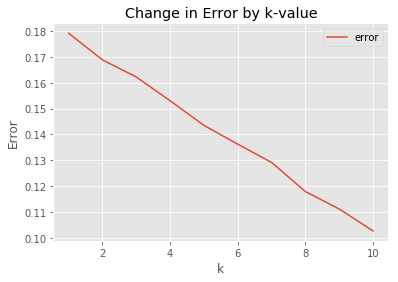

In [303]:
errors = pd.DataFrame(errors, columns = ['k','error'])
errors.plot(x = 'k', y = 'error', kind='line')

plt.title('Change in Error by k-value')
plt.ylabel('Error')
plt.xlabel('k')

plt.show()

Looking at our error plot, there aren't any significant elbows. This likely means we will end up with some singleton clusters no matter what k value we choose, so we will stick with 5 clusters.

In [319]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(base)

In [320]:
# add clustering labels
neighborhoods_venues_sorted_red['Cluster Labels'] = kmeans.labels_

toronto_merged_final = toronto_data[~toronto_data['Neighborhood'].isin(venues_to_remove)]

toronto_merged_final = toronto_merged_final.join(neighborhoods_venues_sorted_red.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_final.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,1,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Restaurant,Breakfast Spot,Café,Theater,Hotel
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Bakery,Tea Room,Bubble Tea Shop,Pizza Place,Diner
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Hotel,Restaurant,Cosmetics Shop,Breakfast Spot,Clothing Store,Bakery,Gastropub,Diner
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Farmers Market,Bakery,Italian Restaurant,Steakhouse,Beer Bar,Seafood Restaurant,Café,Cheese Shop
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Italian Restaurant,Café,Middle Eastern Restaurant,Burger Joint,Sandwich Place,Indian Restaurant,Japanese Restaurant,Ice Cream Shop,Restaurant
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3,Grocery Store,Café,Park,Restaurant,Convenience Store,Diner,Italian Restaurant,Coffee Shop,Baby Store,Nightclub
7,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,0,Café,Coffee Shop,Steakhouse,American Restaurant,Bar,Burger Joint,Thai Restaurant,Gym,Bakery,Hotel
8,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259,1,Bakery,Supermarket,Pharmacy,Bank,Bar,Brazilian Restaurant,Discount Store,Café,Music Venue,Middle Eastern Restaurant
9,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,1,Coffee Shop,Hotel,Aquarium,Café,Italian Restaurant,Pizza Place,Brewery,Restaurant,Scenic Lookout,Sporting Goods Shop
10,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,0,Bar,Coffee Shop,Asian Restaurant,Men's Store,New American Restaurant,Vietnamese Restaurant,Café,Bakery,Restaurant,Cocktail Bar


#### Visualizing Clusters

Now we look at the different neighborhoods, colored by cluster.

In [327]:
# create map
map_toronto_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_final['Latitude'], toronto_merged_final['Longitude'], 
                                  toronto_merged_final['Neighborhood'], toronto_merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto_clusters)
       
map_toronto_clusters

Just from looking at the map, it seems safe to say that the cluster near the airport probably does belong in its own cluster, and it's not surprising that Davisville North and Christie as they are both also on the outskirts of downtown.